In [1]:
import os
import logging
from typing import List, Optional
import wandb

import numpy as np
import pandas as pd

import torch

import nll_to_po.models.dn_policy as Policy
from nll_to_po.training.utils import (
    train_single_policy,
    setup_logger,
    set_seed_everywhere,
)
import nll_to_po.training.loss as L
import nll_to_po.training.reward as R

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
os.environ["WANDB_SILENT"] = "true"  # Suppress WandB output

<Figure size 640x480 with 0 Axes>

### Data utils

In [2]:
def generate_data_linear(
    input_dim: int,
    output_dim: int,
    train_size: int = 100,
    val_size: int = 100,
    test_size: int = 100,
    init_dist_loc: Optional[float] = None,
    init_dist_scale: Optional[float] = None,
    init_dist_n_samples: int = 1,
    A: Optional[torch.Tensor] = None,
):
    assert input_dim == output_dim, (
        f"input dim {input_dim} is different from output dim {output_dim}"
    )

    set_seed_everywhere(seed=np.random.randint(0, 1e6))

    # resample parameters
    if A is None:
        A = torch.eye(output_dim)
    if init_dist_loc is None:
        init_dist_loc = np.random.uniform(-6.0, 6.0)
    if init_dist_scale is None:
        init_dist_scale = np.random.uniform(0.1, 2.5)

    # Generate input data (uniform in -5,5)
    X_unique = torch.rand((train_size + val_size + test_size, input_dim)) * 10 - 5

    # For training data: repeat each unique X multiple times
    X_train_unique = X_unique[:train_size]
    X_train = X_train_unique.repeat_interleave(init_dist_n_samples, dim=0)

    # Compute mean for training X and sample multiple y values
    mean_y_train = X_train_unique @ A.T + init_dist_loc
    mean_y_train_expanded = mean_y_train.repeat_interleave(init_dist_n_samples, dim=0)
    y_train = (
        mean_y_train_expanded
        + torch.randn(X_train.shape[0], output_dim) * init_dist_scale
    )
    std_y_train = torch.full_like(mean_y_train_expanded, init_dist_scale)

    # For validation data: use unique X without repetition
    X_val = X_unique[train_size : train_size + val_size]
    mean_y_val = X_val @ A.T + init_dist_loc
    y_val = mean_y_val + torch.randn(X_val.shape[0], output_dim) * init_dist_scale
    std_y_val = torch.full_like(mean_y_val, init_dist_scale)

    # For test data: use unique X without repetition
    X_test = X_unique[train_size + val_size :]
    mean_y_test = X_test @ A.T + init_dist_loc
    y_test = mean_y_test + torch.randn(X_test.shape[0], output_dim) * init_dist_scale
    std_y_test = torch.full_like(mean_y_test, init_dist_scale)

    # Create DataLoaders
    train_dataset = torch.utils.data.TensorDataset(
        X_train, y_train, mean_y_train_expanded, std_y_train
    )
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=X_train.shape[0], shuffle=True
    )
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val, mean_y_val, std_y_val)
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=X_val.shape[0], shuffle=False
    )
    test_dataset = torch.utils.data.TensorDataset(
        X_test, y_test, mean_y_test, std_y_test
    )
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=X_test.shape[0], shuffle=False
    )

    return (
        train_dataloader,
        val_dataloader,
        test_dataloader,
        {
            "init_dist_loc": init_dist_loc,
            "init_dist_scale": init_dist_scale,
            "init_dist_n_samples": init_dist_n_samples,
        },
    )


def generate_data_single_point(
    input_dim: int,
    output_dim: int,
    init_dist_loc: Optional[float] = None,
    init_dist_scale: Optional[float] = None,
    init_dist_n_samples: Optional[int] = None,
):
    set_seed_everywhere(seed=np.random.randint(0, 1e6))

    # resample parameters
    if not init_dist_loc:
        init_dist_loc = np.random.uniform(-5.0, 5.0)
    if not init_dist_scale:
        init_dist_scale = np.random.uniform(0.5, 1.5)
    if not init_dist_n_samples:
        init_dist_n_samples = np.random.randint(1, 100)

    # Generate new random data for each experiment
    X = torch.randn(1, input_dim)
    mean_y = torch.ones((1, output_dim)) * init_dist_loc
    mean_y_expanded = mean_y.repeat_interleave(init_dist_n_samples, dim=0)
    y = mean_y_expanded + torch.randn(init_dist_n_samples, output_dim) * init_dist_scale
    X = X.repeat(init_dist_n_samples, 1)  # Repeat X for each sample
    batch_size = X.shape[0]
    std_y = torch.full_like(mean_y_expanded, init_dist_scale)

    # Create a DataLoader
    train_dataset = torch.utils.data.TensorDataset(X, y, mean_y_expanded, std_y)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    return (
        train_dataloader,
        None,
        None,
        {
            "init_dist_loc": init_dist_loc,
            "init_dist_scale": init_dist_scale,
            "init_dist_n_samples": init_dist_n_samples,
        },
    )

### Exp function

In [3]:
def run_exp(
    policy: Policy.MLPPolicy,
    loss_function: L.LossFunction,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: Optional[torch.utils.data.DataLoader] = None,
    test_dataloader: Optional[torch.utils.data.DataLoader] = None,
    config: Optional[dict] = None,
    exp_idx: Optional[int] = 0,
    df_list: List = [],
    use_wandb: bool = False,
    wandb_project: str = "tractable",
    n_updates: int = 100,
    learning_rate: float = 0.001,
):
    config["train_size"] = len(train_dataloader)
    if val_dataloader is not None:
        config["val_size"] = len(val_dataloader)
    config["loss_type"] = loss_function.name

    if use_wandb:
        wandb_run = wandb.init(
            project=wandb_project,
            config=config,
        )
    else:
        wandb_run = None
    logger, _, ts_writer = setup_logger(
        logger_name="nll_to_po",
        log_dir="../logs",
        env_id="test_theory",
        exp_name=f"{loss_function.name}_{exp_idx}",
    )
    # Log the configuration
    logger.info(f"%%%%%%%%%%%%%%%%%%%\nconfig:\n{config}\n%%%%%%%%%%%%%%%%%%%%")

    # Run comparison
    _, mse_train_metrics, mse_val_metrics, mse_test_metrics, _ = train_single_policy(
        policy=policy,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        test_dataloader=test_dataloader,
        loss_function=loss_function,
        n_updates=n_updates,
        learning_rate=learning_rate,
        wandb_run=wandb_run,
        tensorboard_writer=ts_writer,
        logger=logger,
        early_stopping_patience=n_updates,
    )

    if use_wandb:
        wandb_run.finish()

    # Save to dataframe
    # train
    df = pd.DataFrame(mse_train_metrics).reset_index()
    df = df.rename(columns={"index": "epoch"})
    for k, v in config.items():
        df[k] = v
    df["experiment"] = exp_idx
    df["train_val"] = "train"
    if "std_0" in df.columns and "std_1" in df.columns:
        df["std_error"] = (
            (
                torch.norm(
                    torch.diag(torch.Tensor(df[["std_0", "std_1"]].values))
                    - config["init_dist_scale"] * torch.eye(2),
                    p=2,
                    dim=-1,
                )
            )
            .mean()
            .item()
        )
    df_list.append(df)
    # val
    df = pd.DataFrame(mse_val_metrics).reset_index()
    df = df.rename(columns={"index": "epoch"})
    for k, v in config.items():
        df[k] = v
    df["experiment"] = exp_idx
    df["train_val"] = "val"
    if "std_0" in df.columns and "std_1" in df.columns:
        df["std_error"] = (
            (
                torch.norm(
                    torch.diag(torch.Tensor(df[["std_0", "std_1"]].values))
                    - config["init_dist_scale"] * torch.eye(2),
                    p=2,
                    dim=-1,
                )
            )
            .mean()
            .item()
        )
    df_list.append(df)
    # Test
    df = pd.DataFrame(mse_test_metrics).reset_index()
    df = df.rename(columns={"index": "epoch"})
    for k, v in config.items():
        df[k] = v
    df["experiment"] = exp_idx
    df["train_val"] = "test"
    if "std_0" in df.columns and "std_1" in df.columns:
        df["std_error"] = (
            (
                torch.norm(
                    torch.diag(torch.Tensor(df[["std_0", "std_1"]].values))
                    - config["init_dist_scale"] * torch.eye(2),
                    p=2,
                    dim=-1,
                )
            )
            .mean()
            .item()
        )
    df_list.append(df)

### Generate data and policy

In [88]:
df_list: list[pd.DataFrame] = []

In [89]:
# Experiment parameters
n_experiments: int = 10
n_updates: int = 100
learning_rate: float = 0.01

# Policy architecture
input_dim: int = 2
output_dim: int = 2
hidden_sizes: list[int] = [64, 64]
fixed_logstd: bool = False

# policy = Policy.LinearGaussian(input_dim, output_dim, fixed_logstd)
policy = Policy.MLPPolicy(input_dim, output_dim, hidden_sizes, fixed_logstd)

# Data generating dist q
single_point: bool = False
generate_new_params_per_exp: bool = True

init_dist_loc: float = 6.0
init_dist_scale: float = 1.75
init_dist_n_samples: int = 10

if single_point:
    train_dataloader, val_dataloader, test_dataloader, data_config = (
        generate_data_single_point(
            input_dim=input_dim,
            output_dim=output_dim,
            init_dist_loc=init_dist_loc,
            init_dist_scale=init_dist_scale,
            init_dist_n_samples=init_dist_n_samples,
        )
    )
else:
    train_size: int = 100
    val_size: int = 100
    # A: torch.Tensor = torch.randn((output_dim, input_dim))
    A: torch.Tensor = torch.eye(output_dim)

    train_dataloader, val_dataloader, test_dataloader, data_config = (
        generate_data_linear(
            input_dim=input_dim,
            output_dim=output_dim,
            train_size=train_size,
            val_size=val_size,
            init_dist_loc=init_dist_loc,
            init_dist_scale=init_dist_scale,
            init_dist_n_samples=init_dist_n_samples,
            A=A,
        )
    )

### Baselines: MSE & NLL

In [90]:
for loss_function in [L.MSE(), L.NLL()]:
    for exp_idx in range(n_experiments):
        if generate_new_params_per_exp:
            if single_point:
                train_dataloader, val_dataloader, test_dataloader, data_config = (
                    generate_data_single_point(
                        input_dim=input_dim,
                        output_dim=output_dim,
                    )
                )
            else:
                train_dataloader, val_dataloader, test_dataloader, data_config = (
                    generate_data_linear(
                        input_dim=input_dim,
                        output_dim=output_dim,
                        train_size=train_size,
                        val_size=val_size,
                        init_dist_n_samples=init_dist_n_samples,
                    )
                )

        config = {
            "fixed_logstd": fixed_logstd,
            "init_dist_loc": data_config["init_dist_loc"],
            "init_dist_scale": data_config["init_dist_scale"],
            "init_dist_n_samples": data_config["init_dist_n_samples"],
            "learning_rate": learning_rate,
        }

        run_exp(
            policy=policy,
            loss_function=loss_function,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            config=config,
            exp_idx=exp_idx,
            df_list=df_list,
            n_updates=n_updates,
            learning_rate=learning_rate,
        )

2025-08-27 00:39:28 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': False, 'init_dist_loc': 0.7894889549326649, 'init_dist_scale': 0.17508236299283234, 'init_dist_n_samples': 10, 'learning_rate': 0.01, 'train_size': 1, 'val_size': 1, 'loss_type': 'MSE'}
%%%%%%%%%%%%%%%%%%%%
2025-08-27 00:39:28 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:02<00:00, 37.98it/s]
2025-08-27 00:39:31 - nll_to_po - INFO - Training completed after 100 epochs
2025-08-27 00:39:31 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': False, 'init_dist_loc': 2.0479556517707938, 'init_dist_scale': 1.0987069548674542, 'init_dist_n_samples': 10, 'learning_rate': 0.01, 'train_size': 1, 'val_size': 1, 'loss_type': 'MSE'}
%%%%%%%%%%%%%%%%%%%%
2025-08-27 00:39:31 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:03<00:00, 32.82it/s]
2025-08-27 00:39:34 - nll_to_po - INFO - Training comple

### PG Entropy Reg

In [91]:
n_generations: int = 5
use_rsample: bool = False
reward_transform: str = "none"

for exp_idx in range(n_experiments):
    if generate_new_params_per_exp:
        if single_point:
            train_dataloader, val_dataloader, data_config = generate_data_single_point(
                input_dim=input_dim,
                output_dim=output_dim,
            )
        else:
            train_dataloader, val_dataloader, test_dataloader, data_config = (
                generate_data_linear(
                    input_dim=input_dim,
                    output_dim=output_dim,
                    train_size=train_size,
                    val_size=val_size,
                    init_dist_n_samples=init_dist_n_samples,
                )
            )
    entropy_list = [round(lamda, 2) for lamda in np.logspace(-1, 1, num=6)][:-1]
    # entropy_list = [10.0]
    for entropy_weight in entropy_list:
        for reward_constant_diagonal in [
            1.0,
            (entropy_weight) / (2 * (data_config["init_dist_scale"] ** 2)),
        ]:
            # Define reward function
            reward_fn = R.Mahalanobis(
                matrix=reward_constant_diagonal * torch.eye(output_dim)
            )

            config = {
                "fixed_logstd": fixed_logstd,
                "init_dist_loc": data_config["init_dist_loc"],
                "init_dist_scale": data_config["init_dist_scale"],
                "init_dist_n_samples": data_config["init_dist_n_samples"],
                "learning_rate": learning_rate,
                "n_generations": n_generations,
                "use_rsample": use_rsample,
                "reward_transform": reward_transform,
                "entropy_weight": entropy_weight,
                "reward_fn": reward_fn.name,
                "U": r"PG($\mathrm{U}=\mathrm{I}_n$)"
                if reward_constant_diagonal == 1.0
                else r"PG($\mathrm{U}^\star=\frac{\lambda n}{2 \operatorname{Tr}(\Sigma)}\mathrm{I}_n$)",
            }

            # Define the loss function
            loss_function = L.PG(
                reward_fn=reward_fn,
                n_generations=n_generations,
                use_rsample=use_rsample,
                reward_transform=reward_transform,
                entropy_weight=entropy_weight,
            )
            run_exp(
                policy=policy,
                loss_function=loss_function,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                test_dataloader=test_dataloader,
                config=config,
                exp_idx=exp_idx,
                df_list=df_list,
                n_updates=n_updates,
                learning_rate=learning_rate,
            )

2025-08-27 00:40:22 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': False, 'init_dist_loc': 0.7997116789955232, 'init_dist_scale': 1.1187750312465872, 'init_dist_n_samples': 10, 'learning_rate': 0.01, 'n_generations': 5, 'use_rsample': False, 'reward_transform': 'none', 'entropy_weight': np.float64(0.1), 'reward_fn': 'Mahalanobis($I$)', 'U': 'PG($\\mathrm{U}=\\mathrm{I}_n$)', 'train_size': 1, 'val_size': 1, 'loss_type': 'PG(lam=0.1)_Mahalanobis($I$)'}
%%%%%%%%%%%%%%%%%%%%
2025-08-27 00:40:22 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:03<00:00, 28.89it/s]
2025-08-27 00:40:25 - nll_to_po - INFO - Training completed after 100 epochs
2025-08-27 00:40:25 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': False, 'init_dist_loc': 0.7997116789955232, 'init_dist_scale': 1.1187750312465872, 'init_dist_n_samples': 10, 'learning_rate': 0.01, 'n_generations': 5, 'use_rsample': False, 'reward_transform': 'none'

### plot

In [92]:
df_all = pd.concat(df_list, ignore_index=True)
df_all.head(3)

,epoch,mean_error,loss,grad_norm,fixed_logstd,init_dist_loc,init_dist_scale,init_dist_n_samples,learning_rate,train_size,...,std_0,std_1,std_error,reward_mean,n_generations,use_rsample,reward_transform,entropy_weight,reward_fn,U
0,0,3.064808,9.427948,10.022843,False,0.789489,0.175082,10,0.01,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2.558116,6.577641,8.785624,False,0.789489,0.175082,10,0.01,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.076214,4.342827,9.064557,False,0.789489,0.175082,10,0.01,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


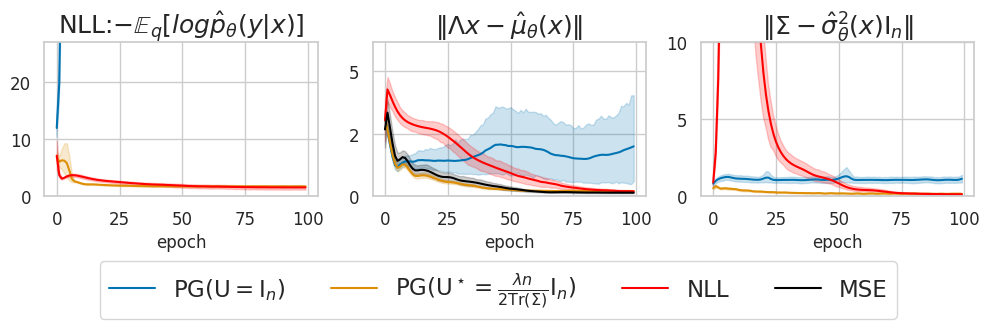

In [95]:
sub_df = df_all.copy()
# sub_df["entropy_weight"] = sub_df["entropy_weight"].astype("str")

metric_name = []
metric_name.append(("NLL", r"NLL:$-\mathbb{E}_q[log\hat{p}_\theta(y|x)]$"))
metric_name.append(("mean_error", r"$\|\Lambda x-\hat{\mu}_\theta(x)\|$"))
# metric_name.append(("std_error", r"$\|\Sigma-\hat{\sigma}^2_\theta I\|$"))
# metric_name.append(("sigma_norm", r"$\|\hat{\sigma}^2_\theta\|$"))
metric_name.append(
    ("sigma_error", r"$\|\Sigma-\hat{\sigma}^2_\theta(x) \mathrm{I}_n\|$")
)
# metric_name.append(("reward_mean", r"$R_U$"))

_, ax = plt.subplots(1, len(metric_name), figsize=(12, 2), gridspec_kw=dict(wspace=0.2))
for i, (metric, name) in enumerate(metric_name):
    sns.lineplot(
        data=sub_df[sub_df["train_val"] == "val"],
        x="epoch",
        y=metric,
        hue="U",  # "entropy_weight",
        # style="U",
        ax=ax[i],
        legend=False if i != 1 else True,
        # palette="Spectral",
        errorbar=("ci", 95),
    )
    sns.lineplot(
        data=sub_df[sub_df["loss_type"] == "NLL"],
        x="epoch",
        y=metric,
        ax=ax[i],
        color="red",
        label="NLL" if i == 1 else None,
        errorbar=("ci", 95),
    )
    if metric == "mean_error":
        sns.lineplot(
            data=sub_df[sub_df["loss_type"] == "MSE"],
            x="epoch",
            y=metric,
            ax=ax[i],
            color="black",
            label="MSE" if i == 1 else None,
            errorbar=("ci", 95),
        )
    # if metric != "reward_mean":
    max_for_lim = sub_df[sub_df["loss_type"] == "NLL"][metric].max()
    ax[i].set_ylim(
        min(sub_df[sub_df["loss_type"] == "NLL"][metric].min(), 0.0),
        max_for_lim if metric != "sigma_error" else 10,  # + max_for_lim / 2,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(name)
    ax[i].tick_params(axis="y", labelsize=12)
    ax[i].tick_params(axis="x", labelsize=12)
    ax[i].set_xlabel("epoch", fontsize=12)
    # ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[i].locator_params(axis="y", nbins=3)
    ax[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0f}"))
ax[1].legend(bbox_to_anchor=(0.46, -0.87), loc="lower center", ncol=4)
plt.savefig("../figures/toy_avg_new.pdf", bbox_inches="tight")
plt.show()

### ablations

In [24]:
def plot_ablation(
    df: pd.DataFrame,
    hue_variable: str,
    style_variable: Optional[str] = None,
    loss_type_list: List[str] = [],
    use_rsample_list: List[bool] = [],
    n_generations_list: List[int] = [],
    entropy_weight_list: List[float] = [],
    reward_transform_list: List[str] = [],
):
    sub_df = df.copy()
    if loss_type_list:
        sub_df = sub_df[sub_df["loss_type"].isin(loss_type_list)]
    if use_rsample_list:
        sub_df = sub_df[sub_df["use_rsample"].isin(use_rsample_list)]
    if n_generations_list:
        sub_df = sub_df[sub_df["n_generations"].isin(n_generations_list)]
    if entropy_weight_list:
        sub_df = sub_df[sub_df["entropy_weight"].isin(entropy_weight_list)]
    if reward_transform_list:
        sub_df = sub_df[sub_df["reward_transform"].isin(reward_transform_list)]

    sub_df["entropy_weight"] = sub_df["entropy_weight"].astype("str")

    _, ax = plt.subplots(1, 5, figsize=(20, 4))
    for i, metric in enumerate(
        ["loss", "NLL", "mean_error", "grad_norm", "reward_mean"]
    ):
        sns.lineplot(
            data=sub_df[sub_df["train_val"] == "train"],
            x="epoch",
            y=metric,
            hue=hue_variable,
            style=style_variable,
            ax=ax[i],
            legend=False if i > 0 else True,
        )
        ax[i].set_ylabel(None)
        ax[i].set_title(metric)
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[0].legend(bbox_to_anchor=(2.5, -0.55), loc="lower center", ncol=4, frameon=False)

    _, ax = plt.subplots(1, 4, figsize=(20, 4))
    for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm"]):
        sns.lineplot(
            data=sub_df[sub_df["train_val"] == "val"],
            x="epoch",
            y=metric,
            hue=hue_variable,
            style=style_variable,
            ax=ax[i],
            legend=False if i > 0 else True,
        )
        ax[i].set_ylabel(None)
        ax[i].set_title(metric)
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[0].legend(bbox_to_anchor=(2.5, -0.55), loc="lower center", ncol=6, frameon=False)
    plt.show()

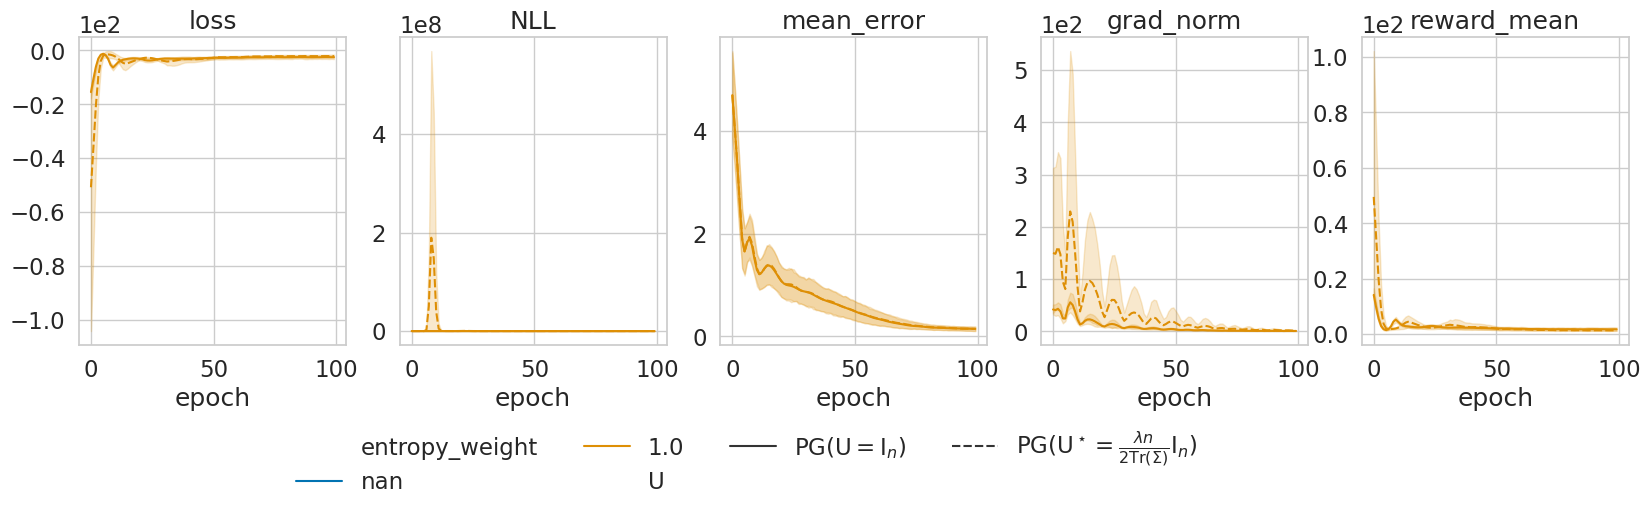

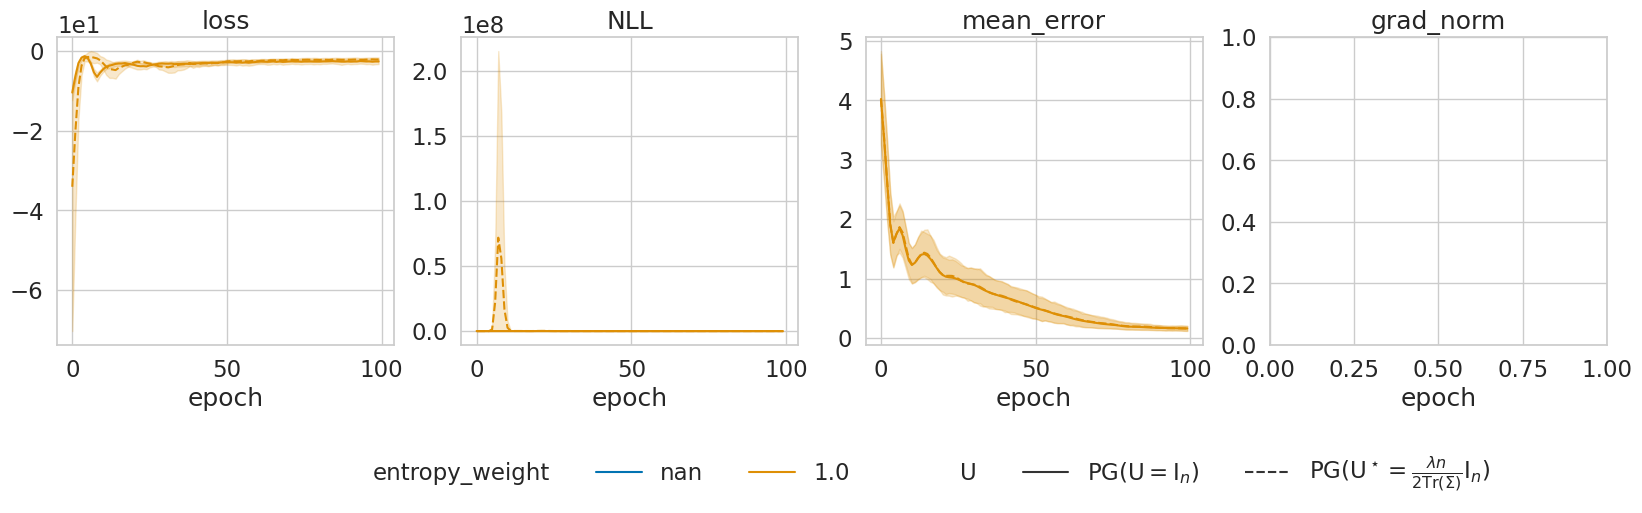

In [25]:
plot_ablation(
    df=df_all,
    hue_variable="entropy_weight",
    style_variable="U",
    loss_type_list=[],
    use_rsample_list=[],
    n_generations_list=[],
    entropy_weight_list=[],
    reward_transform_list=[],
)